# AnnNet — Quick Tutorial

This notebook gives a **compact tour** of AnnNet:

- Creating expressive biological graphs  
- Adding annotations everywhere  
- Working with slices (conditions)  
- Using hyperedges (complexes / reactions)  
- Simple multilayer example  
- Interoperability (NetworkX + PyTorch Geometric  + Cytoscape's cx2 export)  
- Saving and reloading

In [1]:
# . Setup & Initialization

import numpy as np
import polars as pl
from scipy.sparse.linalg import eigsh
from collections import defaultdict

import sys
import os
sys.path.insert(0, os.path.abspath(".."))
from annnet.core.graph import AnnNet

# visualization
import matplotlib.pyplot as plt

In [2]:
# . Initialize AnnNet with Full Configuration

G = AnnNet(directed=None, n=100, e=300)  # None = mixed directionality allowed

# Enable mutation history
G.enable_history(True)
G.mark("initialization")

# Set graph-level attributes (unstructured metadata / G.uns)
G.graph_attributes["name"] = "Multi-Omic Disease Network"
G.graph_attributes["organism"] = "Homo sapiens"
G.graph_attributes["disease_context"] = "inflammatory_pathway"

print(f"AnnNet initialized: capacity={G._matrix.shape}, history={G._history_enabled}")
print(f"AnnNet attributes: {G.graph_attributes}")


AnnNet initialized: capacity=(100, 300), history=True
AnnNet attributes: {'name': 'Multi-Omic Disease Network', 'organism': 'Homo sapiens', 'disease_context': 'inflammatory_pathway'}


In [4]:
# . Define Multilayer Structure (Kivelä Formalism)

# Define multi-aspect structure
G.set_aspects(
    aspects=["omic"],
    elem_layers={
        "omic": ["PPI", "metabolic", "regulatory", "phenotype"]
    }
)

# Set aspect-level metadata
G.set_aspect_attrs("omic",
    description="Biological interaction layer",
    data_sources=["STRING", "KEGG", "TRRUST", "DisGeNET"]
)

# Set layer-level metadata
G.set_layer_attrs(("PPI",), 
    interaction_type="physical",
    evidence="experimental",
    database="STRING"
)
G.set_layer_attrs(("metabolic",),
    interaction_type="enzymatic", 
    pathways=["glycolysis", "TCA", "lipid"],
    database="KEGG"
)
G.set_layer_attrs(("regulatory",),
    interaction_type="transcriptional",
    direction="TF_to_target",
    database="TRRUST"
)
G.set_layer_attrs(("phenotype",),
    interaction_type="association",
    evidence="GWAS",
    database="DisGeNET"
)

print(f"Aspects: {G.aspects}")
print(f"Layers: {G.elem_layers}")
print(f"\n Aspects View")
print(G.aspects_view())
print(f"\n Layers View")
print(G.layers_view())

Aspects: ['omic']
Layers: {'omic': ['PPI', 'metabolic', 'regulatory', 'phenotype']}

 Aspects View
shape: (1, 4)
┌────────┬────────────────────────┬──────────────────────────────┬──────────────────────┐
│ aspect ┆ elem_layers            ┆ description                  ┆ data_sources         │
│ ---    ┆ ---                    ┆ ---                          ┆ ---                  │
│ str    ┆ list[str]              ┆ str                          ┆ list[str]            │
╞════════╪════════════════════════╪══════════════════════════════╪══════════════════════╡
│ omic   ┆ ["PPI", "metabolic", … ┆ Biological interaction layer ┆ ["STRING", "KEGG", … │
│        ┆ "phenot…               ┆                              ┆ "DisGeNET…           │
└────────┴────────────────────────┴──────────────────────────────┴──────────────────────┘

 Layers View
shape: (4, 8)
┌────────────┬────────────┬────────────┬────────────┬───────────┬──────────┬───────────┬───────────┐
│ layer_tupl ┆ layer_id   ┆ omic      

In [9]:
# . Create Biological Entities

# Genes/proteins
genes = ["GENE_A", "GENE_B", "GENE_C", "GENE_D", "GENE_E", 
         "GENE_F", "GENE_G", "GENE_H", "GENE_I", "GENE_J"]
tfs = ["GENE_A", "GENE_C", "GENE_F"]
enzymes = ["GENE_B", "GENE_D", "GENE_G", "GENE_I"]

# Metabolites
metabolites = ["MET_1", "MET_2", "MET_3", "MET_4", "MET_5", "MET_6"]

# Phenotypes
phenotypes = ["inflammation", "cell_death", "proliferation", "immune_response"]

# Add genes with attributes


In [10]:
G.vertex_attributes

vertex_id,entity_type,is_enzyme,is_tf
str,str,bool,bool
"""GENE_A""","""gene""",false,true
"""GENE_B""","""gene""",true,false
"""GENE_C""","""gene""",false,true
"""GENE_D""","""gene""",true,false
"""GENE_E""","""gene""",false,false
"""GENE_F""","""gene""",false,true
"""GENE_G""","""gene""",true,false
"""GENE_H""","""gene""",false,false
"""GENE_I""","""gene""",true,false


In [12]:
# . Create Biological Entities

# Genes/proteins
genes = ["GENE_A", "GENE_B", "GENE_C", "GENE_D", "GENE_E", 
         "GENE_F", "GENE_G", "GENE_H", "GENE_I", "GENE_J"]
tfs = ["GENE_A", "GENE_C", "GENE_F"]
enzymes = ["GENE_B", "GENE_D", "GENE_G", "GENE_I"]

# Metabolites
metabolites = ["MET_1", "MET_2", "MET_3", "MET_4", "MET_5", "MET_6"]

# Phenotypes
phenotypes = ["inflammation", "cell_death", "proliferation", "immune_response"]

# Add genes with attributes
for g in genes:
    G.add_vertex(g,
        entity_type="gene",
        is_tf=(g in tfs),
        is_enzyme=(g in enzymes),
        chromosome=np.random.randint(1, 23),
        expression_level=np.random.uniform(0, 100),
        druggable=np.random.choice([True, False]),
        annotation_source="Ensembl"
    )

# Add metabolites
for i, m in enumerate(metabolites):
    G.add_vertex(m,
        entity_type="metabolite",
        molecular_weight=100 + i * 50,
        pathway="glycolysis" if i < 3 else "lipid",
        KEGG_id=f"C{10000 + i}",
        concentration_uM=np.random.uniform(1, 1000)
    )

# Add phenotypes
for p in phenotypes:
    G.add_vertex(p,
        entity_type="phenotype",
        category="disease" if p in ["inflammation", "cell_death"] else "process",
        MeSH_id=f"D{np.random.randint(10000, 99999)}",
        severity_score=np.random.uniform(0, 1)
    )

""" For bulk operations, can replace by: 
G.add_vertices_bulk(({"vertex_id": g, "entity_type" : "gene", "is_tf" : (g in tfs), "is_enzyme" : (g in enzymes)} for g in genes))
"""
G.mark("vertices_added")
print(f"Total vertices: {G.number_of_vertices()}")




Total vertices: 20


In [13]:
# . Vertex Attribute Views

# Full vertex attribute table
print("=== Complete Vertex Attributes ===")
print(G.vertices_view())

# Filter by entity type using Polars
vertex_df = G.vertices_view()
print("\n=== Genes Only ===")
genes_df = vertex_df.filter(pl.col("entity_type") == "gene")
print(genes_df)

=== Complete Vertex Attributes ===
shape: (20, 15)
┌─────────────┬─────────────┬───────────┬───────┬───┬────────────┬──────────┬─────────┬────────────┐
│ vertex_id   ┆ entity_type ┆ is_enzyme ┆ is_tf ┆ … ┆ concentrat ┆ category ┆ MeSH_id ┆ severity_s │
│ ---         ┆ ---         ┆ ---       ┆ ---   ┆   ┆ ion_uM     ┆ ---      ┆ ---     ┆ core       │
│ str         ┆ str         ┆ bool      ┆ bool  ┆   ┆ ---        ┆ str      ┆ str     ┆ ---        │
│             ┆             ┆           ┆       ┆   ┆ f64        ┆          ┆         ┆ f64        │
╞═════════════╪═════════════╪═══════════╪═══════╪═══╪════════════╪══════════╪═════════╪════════════╡
│ GENE_A      ┆ gene        ┆ false     ┆ true  ┆ … ┆ null       ┆ null     ┆ null    ┆ null       │
│ GENE_B      ┆ gene        ┆ true      ┆ false ┆ … ┆ null       ┆ null     ┆ null    ┆ null       │
│ GENE_C      ┆ gene        ┆ false     ┆ true  ┆ … ┆ null       ┆ null     ┆ null    ┆ null       │
│ GENE_D      ┆ gene        ┆ true      

In [14]:
# . Define Layer Presence (V_M)

# PPI layer: all genes
for g in genes:
    G.add_presence(g, ("PPI",))

# Metabolic layer: metabolites + enzymes
for m in metabolites:
    G.add_presence(m, ("metabolic",))
for e in enzymes:
    G.add_presence(e, ("metabolic",))

# Regulatory layer: all genes (TF -> target relationships)
for g in genes:
    G.add_presence(g, ("regulatory",))

# Phenotype layer: phenotypes + disease-associated genes
for p in phenotypes:
    G.add_presence(p, ("phenotype",))
for g in ["GENE_A", "GENE_C", "GENE_F", "GENE_H"]:
    G.add_presence(g, ("phenotype",))

# Set vertex-layer specific attributes
G.set_vertex_layer_attrs("GENE_A", ("PPI",), ppi_degree=5, hub_score=0.9)
G.set_vertex_layer_attrs("GENE_A", ("regulatory",), n_targets=3, tf_activity=0.8)
G.set_vertex_layer_attrs("GENE_A", ("phenotype",), disease_association=0.95)

print(f"Total (vertex, layer) pairs: {len(G._VM)}")
for layer in [("PPI",), ("metabolic",), ("regulatory",), ("phenotype",)]:
    verts = G.layer_vertex_set(layer)
    print(f"  {layer[0]}: {len(verts)} entities")

Total (vertex, layer) pairs: 38
  PPI: 10 entities
  metabolic: 10 entities
  regulatory: 10 entities
  phenotype: 8 entities


In [17]:
# . Build Intra-Layer Edges with

# Binary Edge Expressiveness:
# - Weighted edges
# - Directed vs undirected; edge level and graph level; flexible directionality 
# - Parallel edges
# - Self-loops
# - Edge attributes
# - Hybrid edges (edge-edge; vertex-edge)

# === PPI Layer (UNDIRECTED, weighted) ===
ppi_edges = [
    ("GENE_A", "GENE_B", 0.9),
    ("GENE_A", "GENE_C", 0.8),
    ("GENE_A", "GENE_D", 0.7),
    ("GENE_A", "GENE_E", 0.6),
    ("GENE_B", "GENE_C", 0.5),
    ("GENE_B", "GENE_F", 0.8),
    ("GENE_C", "GENE_G", 0.7),
    ("GENE_D", "GENE_H", 0.6),
    ("GENE_E", "GENE_F", 0.5),
    ("GENE_F", "GENE_G", 0.9),
    ("GENE_F", "GENE_H", 0.7),
    ("GENE_G", "GENE_I", 0.6),
    ("GENE_H", "GENE_I", 0.8),
    ("GENE_I", "GENE_J", 0.9),
    ("GENE_J", "GENE_A", 0.4),
]

for src, tgt, w in ppi_edges:
    eid = G.add_intra_edge_nl(src, tgt, ("PPI",), weight=w)
    # Add edge attributes
    G.set_edge_attrs(eid, 
        interaction_type="physical",
        evidence_score=w,
        detection_method="co-IP" if w > 0.7 else "Y2H",
        pubmed_ids=[f"PMID{np.random.randint(10000000, 99999999)}"]
    )

# === SELF-LOOP: Gene A auto-regulation ===
self_loop_eid = G.add_intra_edge_nl("GENE_A", "GENE_A", ("PPI",), weight=0.3)
G.set_edge_attrs(self_loop_eid,
    interaction_type="homodimerization",
    evidence_score=0.3,
    note="GENE_A forms homodimer"
)
print(f"Self-loop added: {self_loop_eid}")

# === PARALLEL EDGES: Multiple evidence types ===
# Two different experiments detected GENE_B - GENE_F interaction
parallel_eid_1 = G.add_intra_edge_nl("GENE_B", "GENE_F", ("PPI",), weight=0.75,
                                      eid="GENE_B--GENE_F@PPI_coIP")
G.set_edge_attrs(parallel_eid_1, detection_method="co-IP", experiment_id="EXP001")

parallel_eid_2 = G.add_intra_edge_nl("GENE_B", "GENE_F", ("PPI",), weight=0.65,
                                      eid="GENE_B--GENE_F@PPI_Y2H")
G.set_edge_attrs(parallel_eid_2, detection_method="Y2H", experiment_id="EXP002")

print(f"Parallel edges: {parallel_eid_1}, {parallel_eid_2}")

# === Metabolic Layer (UNDIRECTED for enzyme-metabolite associations) ===
metabolic_edges = [
    ("GENE_B", "MET_1", 1.0),
    ("GENE_B", "MET_2", 1.0),
    ("MET_1", "MET_2", 0.8),
    ("GENE_D", "MET_2", 1.0),
    ("GENE_D", "MET_3", 1.0),
    ("MET_2", "MET_3", 0.9),
    ("GENE_G", "MET_3", 1.0),
    ("GENE_G", "MET_4", 1.0),
    ("MET_3", "MET_4", 0.7),
    ("GENE_I", "MET_4", 1.0),
    ("GENE_I", "MET_5", 1.0),
    ("GENE_I", "MET_6", 1.0),
    ("MET_4", "MET_5", 0.6),
    ("MET_5", "MET_6", 0.8),
]

for src, tgt, w in metabolic_edges:
    eid = G.add_intra_edge_nl(src, tgt, ("metabolic",), weight=w)
    # Determine if enzyme-metabolite or metabolite-metabolite
    src_type = G.get_vertex_attrs(src).get("entity_type")
    tgt_type = G.get_vertex_attrs(tgt).get("entity_type")
    if src_type == "gene" or tgt_type == "gene":
        G.set_edge_attrs(eid, reaction_type="catalysis", reversible=False)
    else:
        G.set_edge_attrs(eid, reaction_type="conversion", reversible=True)

# === Regulatory Layer (DIRECTED: TF -> Target) ===
regulatory_edges = [
    ("GENE_A", "GENE_B", 0.9, "activation"),
    ("GENE_A", "GENE_D", 0.8, "activation"),
    ("GENE_A", "GENE_E", 0.7, "activation"),
    ("GENE_C", "GENE_F", 0.9, "activation"),
    ("GENE_C", "GENE_G", 0.8, "repression"),  # repression
    ("GENE_C", "GENE_H", 0.6, "activation"),
    ("GENE_F", "GENE_I", 0.9, "activation"),
    ("GENE_F", "GENE_J", 0.7, "activation"),
    ("GENE_H", "GENE_A", 0.3, "repression"),  # negative feedback
]

for src, tgt, w, reg_type in regulatory_edges:
    # Regulatory edges are DIRECTED
    eid = G.add_edge(src, tgt, weight=w, edge_directed=True,
                     layer=("regulatory",)[0])
    G.set_edge_attrs(eid,
        regulation_type=reg_type,
        binding_site="promoter",
        confidence=w
    )
    # Also annotate with Kivelä role
    G.set_edge_kivela_role(eid, "intra", ("regulatory",))

# === Phenotype Layer (UNDIRECTED associations) ===
phenotype_edges = [
    ("GENE_A", "inflammation", 0.9),
    ("GENE_A", "immune_response", 0.7),
    ("GENE_C", "cell_death", 0.8),
    ("GENE_F", "proliferation", 0.9),
    ("GENE_F", "inflammation", 0.5),
    ("GENE_H", "cell_death", 0.6),
    ("GENE_H", "immune_response", 0.4),
    ("inflammation", "immune_response", 0.8),
    ("cell_death", "inflammation", 0.6),
    ("proliferation", "cell_death", 0.4),
]

for src, tgt, w in phenotype_edges:
    eid = G.add_intra_edge_nl(src, tgt, ("phenotype",), weight=w)
    G.set_edge_attrs(eid,
        association_type="GWAS" if "GENE" in src else "comorbidity",
        p_value=10**(-w*10),
        odds_ratio=1 + w*2
    )

G.mark("intra_edges_added")
print(f"\nTotal edges after intra-layer: {G.number_of_edges()}")
for layer in [("PPI",), ("metabolic",), ("regulatory",), ("phenotype",)]:
    edges = G.layer_edge_set(layer)
    print(f"  {layer[0]}: {len(edges)} edges")

Self-loop added: GENE_A>GENE_A@PPI
Parallel edges: GENE_B--GENE_F@PPI_coIP, GENE_B--GENE_F@PPI_Y2H

Total edges after intra-layer: 51
  PPI: 18 edges
  metabolic: 14 edges
  regulatory: 9 edges
  phenotype: 10 edges


In [30]:
# . Edge Attribute Views

G.edge_attributes.head(3)

edge_id,layer,interaction_type,evidence_score,detection_method,pubmed_ids,note,experiment_id,reaction_type,reversible,regulation_type,binding_site,confidence,association_type,p_value,odds_ratio
str,str,str,f64,str,list[str],str,str,str,bool,str,str,f64,str,f64,f64
"""GENE_A>GENE_B@PPI""","""PPI""","""physical""",0.9,"""co-IP""","[""[""PMID36101508""]""]",null,null,null,null,null,null,null,null,null,null
"""GENE_A>GENE_C@PPI""","""PPI""","""physical""",0.8,"""co-IP""","[""[""PMID47126846""]""]",null,null,null,null,null,null,null,null,null,null
"""GENE_A>GENE_D@PPI""","""PPI""","""physical""",0.7,"""Y2H""","[""[""PMID46793962""]""]",null,null,null,null,null,null,null,null,null,null


In [10]:
# . Hyperedges: Protein Complexes (Undirected)

# Protein complexes as undirected hyperedges
complexes = [
    {
        "name": "TF_complex_A",
        "members": ["GENE_A", "GENE_B", "GENE_C"],
        "function": "transcription_initiation"
    },
    {
        "name": "signaling_hub",
        "members": ["GENE_F", "GENE_G", "GENE_H", "GENE_I"],
        "function": "signal_transduction"
    },
    {
        "name": "metabolic_complex",
        "members": ["GENE_B", "GENE_D", "MET_2"],
        "function": "metabolon"
    }
]

for cplx in complexes:
    valid_members = [m for m in cplx["members"] if m in G.entity_to_idx]
    if len(valid_members) >= 2:
        heid = G.add_hyperedge(
            members=valid_members,
            edge_id=f"complex_{cplx['name']}",
            weight=1.0
        )
        G.set_edge_attrs(heid,
            complex_name=cplx["name"],
            function=cplx["function"],
            n_subunits=len(valid_members),
            stoichiometry="1:1:1"
        )
        print(f"Added hyperedge: {heid} with {len(valid_members)} members")

print(f"\nHyperedge definitions: {G.hyperedge_definitions}")

Added hyperedge: complex_TF_complex_A with 3 members
Added hyperedge: complex_signaling_hub with 4 members
Added hyperedge: complex_metabolic_complex with 3 members

Hyperedge definitions: {'complex_TF_complex_A': {'directed': False, 'members': {'GENE_C', 'GENE_A', 'GENE_B'}}, 'complex_signaling_hub': {'directed': False, 'members': {'GENE_I', 'GENE_G', 'GENE_F', 'GENE_H'}}, 'complex_metabolic_complex': {'directed': False, 'members': {'GENE_D', 'MET_2', 'GENE_B'}}}


In [31]:
# . Hyperedges: Multi-Substrate Reactions (Directed)

# Directed hyperedges for metabolic reactions
# head = substrates/enzymes, tail = products

directed_reactions = [
    {
        "name": "glycolysis_step1",
        "head": ["MET_1", "GENE_B"],  # substrate + enzyme
        "tail": ["MET_2"],             # product
        "stoich": {"MET_1": -1, "MET_2": 1}
    },
    {
        "name": "glycolysis_step2", 
        "head": ["MET_2", "GENE_D"],
        "tail": ["MET_3"],
        "stoich": {"MET_2": -1, "MET_3": 1}
    },
    {
        "name": "branch_point",
        "head": ["MET_3", "GENE_G"],
        "tail": ["MET_4", "MET_5"],  # two products
        "stoich": {"MET_3": -1, "MET_4": 0.5, "MET_5": 0.5}
    }
]

for rxn in directed_reactions:
    valid_head = [h for h in rxn["head"] if h in G.entity_to_idx]
    valid_tail = [t for t in rxn["tail"] if t in G.entity_to_idx]
    
    if valid_head and valid_tail:
        heid = G.add_hyperedge(
            head=valid_head,
            tail=valid_tail,
            edge_id=f"rxn_{rxn['name']}",
            weight=1.0
        )
        G.set_edge_attrs(heid,
            reaction_name=rxn["name"],
            EC_number=f"EC:1.1.1.{np.random.randint(1,100)}",
            delta_G=-np.random.uniform(5, 30)
        )
        # Set stoichiometric coefficients
        G.set_hyperedge_coeffs(heid, rxn["stoich"])
        print(f"Added directed hyperedge: {heid}")

G.mark("hyperedges_added")

Added directed hyperedge: rxn_glycolysis_step1
Added directed hyperedge: rxn_glycolysis_step2
Added directed hyperedge: rxn_branch_point


In [24]:
# Flexible directionality API tuto

# Helper to read signs
def signs(G, eid):
    s,t,_ = G.edge_definitions[eid]
    col = G.edge_to_idx[eid]
    si = G.entity_to_idx[s]; ti = G.entity_to_idx[t]
    M = G._matrix
    return M.get((si,col),0), M.get((ti,col),0)

# Vertex-scope policy
G2 = AnnNet()
G2.set_vertex_key("name","sex")
s = G2.get_or_create_vertex_by_attrs(name="a", sex="man")
t = G2.get_or_create_vertex_by_attrs(name="a", sex="woman")
G2.set_vertex_attrs(s, temp=10.0)
G2.set_vertex_attrs(t, temp=20.0)

e2 = G2.add_edge(s, t,
    flexible={"var":"temp","threshold":0.0,"scope":"vertex","above":"s->t","tie":"undirected"},
    weight=1.0) #"tie" can be: undirected, keep, s>t or t>s

print("xs<xt:", signs(G2,e2))         # (-1, +1)
G2.set_vertex_attrs(s, temp=25.0)
print("xs>xt:", signs(G2,e2))         # (+1, -1)
G2.set_vertex_attrs(t, temp=25.0)
print("tie  :", signs(G2,e2))         # since "tie":"undirected", it becomes: (+1, +1)


xs<xt: (np.float32(-1.0), np.float32(1.0))
xs>xt: (np.float32(1.0), np.float32(-1.0))
tie  : (np.float32(1.0), np.float32(1.0))


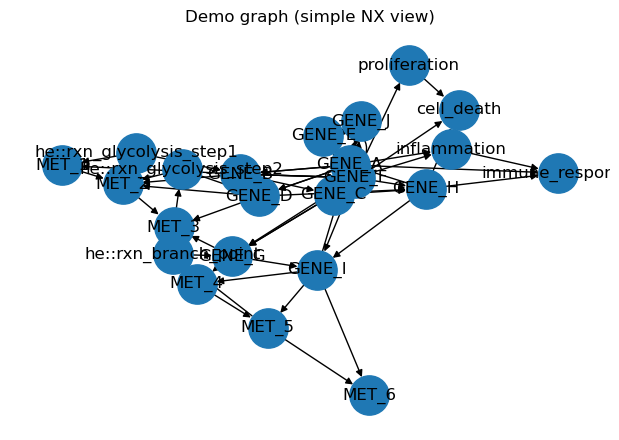

In [32]:
import annnet.adapters.networkx_adapter as anx
import networkx as nx

# Obtain a simple NX view (collapse Multi* edges with sensible aggregations)
nxG, manifest = anx.to_nx(G, directed=True, hyperedge_mode="reify") # skip, expand or reify
pos = nx.spring_layout(nxG, seed=42)
plt.figure(figsize=(6,4))
nx.draw(nxG, pos, with_labels=True, node_size=800)
nx.draw_networkx_edge_labels(nxG, pos, edge_labels=nx.get_edge_attributes(nxG, 'weight'))
plt.title('Demo graph (simple NX view)')
plt.show()

In [33]:
# . Inter-Layer Coupling Edges

omega = 1.0  # coupling strength

# PPI <-> regulatory (all genes)
for g in genes:
    G.add_coupling_edge_nl(g, ("PPI",), ("regulatory",), weight=omega)

# PPI <-> metabolic (enzymes only)
for e in enzymes:
    G.add_coupling_edge_nl(e, ("PPI",), ("metabolic",), weight=omega)

# regulatory <-> metabolic (enzymes only)
for e in enzymes:
    G.add_coupling_edge_nl(e, ("regulatory",), ("metabolic",), weight=omega)

# PPI <-> phenotype (disease genes)
for g in ["GENE_A", "GENE_C", "GENE_F", "GENE_H"]:
    G.add_coupling_edge_nl(g, ("PPI",), ("phenotype",), weight=omega)

# regulatory <-> phenotype (disease genes)
for g in ["GENE_A", "GENE_C", "GENE_F", "GENE_H"]:
    G.add_coupling_edge_nl(g, ("regulatory",), ("phenotype",), weight=omega)

coupling_edges = [e for e, k in G.edge_kind.items() if k == "coupling"]
print(f"Total edges after coupling: {G.number_of_edges()}")
print(f"Coupling edges: {len(coupling_edges)}")
G.mark("coupling_edges_added")

Total edges after coupling: 80
Coupling edges: 26


In [34]:
# . Slices: Named Subgraph Partitions

# Create slices from layers
for layer in ["PPI", "metabolic", "regulatory", "phenotype"]:
    G.create_slice_from_layer(
        slice_id=f"layer_{layer}",
        layer_tuple=(layer,),
        source="layer_extraction",
        description=f"All entities in {layer} layer"
    )

# Create functional slices
G.add_slice("hub_genes", description="High-degree genes")
for g in ["GENE_A", "GENE_F"]:  # known hubs
    G._slices["hub_genes"]["vertices"].add(g)

G.add_slice("disease_associated", description="Phenotype-linked genes")
for g in ["GENE_A", "GENE_C", "GENE_F", "GENE_H"]:
    G._slices["disease_associated"]["vertices"].add(g)

G.add_slice("enzymes_only", description="Metabolic enzymes")
for e in enzymes:
    G._slices["enzymes_only"]["vertices"].add(e)

# Set slice attributes
G.set_slice_attrs("hub_genes", centrality_threshold=0.8, n_hubs=2)
G.set_slice_attrs("disease_associated", disease="inflammatory", source="DisGeNET")

print("=== Slices View ===")
print(G.slices_view())

print("\n=== Slice Contents ===")
for sid in G.list_slices():
    info = G.get_slice_info(sid)
    print(f"  {sid}: {len(info['vertices'])} vertices, {len(info['edges'])} edges")

=== Slices View ===
shape: (3, 6)
┌────────────────────┬─────────────────────┬────────────────────┬────────┬──────────────┬──────────┐
│ slice_id           ┆ description         ┆ centrality_thresho ┆ n_hubs ┆ disease      ┆ source   │
│ ---                ┆ ---                 ┆ ld                 ┆ ---    ┆ ---          ┆ ---      │
│ str                ┆ str                 ┆ ---                ┆ i64    ┆ str          ┆ str      │
│                    ┆                     ┆ f64                ┆        ┆              ┆          │
╞════════════════════╪═════════════════════╪════════════════════╪════════╪══════════════╪══════════╡
│ hub_genes          ┆ High-degree genes   ┆ 0.8                ┆ 2      ┆ null         ┆ null     │
│ disease_associated ┆ Phenotype-linked    ┆ null               ┆ null   ┆ inflammatory ┆ DisGeNET │
│                    ┆ genes               ┆                    ┆        ┆              ┆          │
│ enzymes_only       ┆ Metabolic enzymes   ┆ null        

In [36]:
# . Slice Set Operations

# Union of slices
hub_disease_union = G.slice_union(["hub_genes", "disease_associated"])
print(f"Hub ∪ Disease: {hub_disease_union['vertices']}")

# Intersection
hub_disease_intersection = G.slice_intersection(["hub_genes", "disease_associated"])
print(f"Hub ∩ Disease: {hub_disease_intersection['vertices']}")

# Difference
disease_not_hub = G.slice_difference("disease_associated", "hub_genes")
print(f"Disease \\ Hub: {disease_not_hub['vertices']}")

# Create new slice from operation
G.create_slice_from_operation(
    "hub_disease_overlap",
    hub_disease_intersection,
    operation="intersection",
    description="Genes that are both hubs and disease-associated"
)

Hub ∪ Disease: {'GENE_A', 'GENE_H', 'GENE_F', 'GENE_C'}
Hub ∩ Disease: {'GENE_A', 'GENE_F'}
Disease \ Hub: {'GENE_H', 'GENE_C'}


'hub_disease_overlap'

In [18]:
# . AnnData-like API

print("=== AnnData-like API ===")

# X() - incidence matrix
X = G.X()
print(f"G.X() shape: {X.shape}, nnz: {X.nnz}")
print(f"  (entities x edges incidence matrix)")

# obs - vertex attributes (observations)
obs = G.obs
print(f"\nG.obs (vertex attributes):")
print(obs.head())

# var - edge attributes (variables)
var = G.var
print(f"\nG.var (edge attributes):")
print(var.head())

# uns - unstructured metadata
uns = G.uns
print(f"\nG.uns (graph attributes):")
print(uns)


=== AnnData-like API ===
G.X() shape: (100, 300), nnz: 155
  (entities x edges incidence matrix)

G.obs (vertex attributes):
shape: (5, 15)
┌───────────┬─────────────┬───────┬───────────┬───┬─────────────┬──────────┬─────────┬─────────────┐
│ vertex_id ┆ entity_type ┆ is_tf ┆ is_enzyme ┆ … ┆ concentrati ┆ category ┆ MeSH_id ┆ severity_sc │
│ ---       ┆ ---         ┆ ---   ┆ ---       ┆   ┆ on_uM       ┆ ---      ┆ ---     ┆ ore         │
│ str       ┆ str         ┆ bool  ┆ bool      ┆   ┆ ---         ┆ str      ┆ str     ┆ ---         │
│           ┆             ┆       ┆           ┆   ┆ f64         ┆          ┆         ┆ f64         │
╞═══════════╪═════════════╪═══════╪═══════════╪═══╪═════════════╪══════════╪═════════╪═════════════╡
│ GENE_A    ┆ gene        ┆ true  ┆ false     ┆ … ┆ null        ┆ null     ┆ null    ┆ null        │
│ GENE_B    ┆ gene        ┆ false ┆ true      ┆ … ┆ null        ┆ null     ┆ null    ┆ null        │
│ GENE_C    ┆ gene        ┆ true  ┆ false     ┆ … ┆ 

In [38]:
# . Lazy NetworkX Proxy (G.nx)

print("=== Lazy NetworkX Proxy ===")
print("Using G.nx.algorithm(G, ...) pattern")

# Degree centrality via lazy proxy

degree_cent = G.nx.degree_centrality(G)

top_degree = sorted(degree_cent.items(), key=lambda x: -x[1])[:5]
print(f"\nTop 5 by degree centrality:")
for node, cent in top_degree:
    print(f"  {node}: {cent:.4f}")

# Betweenness centrality

betweenness = G.nx.betweenness_centrality(G)

top_between = sorted(betweenness.items(), key=lambda x: -x[1])[:5]
print(f"\nTop 5 by betweenness centrality:")
for node, cent in top_between:
    print(f"  {node}: {cent:.4f}")

# PageRank

pagerank = G.nx.pagerank(G, alpha=0.85)

top_pr = sorted(pagerank.items(), key=lambda x: -x[1])[:5]
print(f"\nTop 5 by PageRank:")
for node, pr in top_pr:
    print(f"  {node}: {pr:.4f}")


# Shortest path

path = G.nx.shortest_path(G, "GENE_A", "GENE_F")

sp = []
for i in path:
    sp.append(G.idx.row_to_entity(i))
print(f"\nShortest path GENE_A → inflammation: {(sp)}")

# Community detection (Louvain)

communities = G.nx.louvain_communities(G, seed=79)

print(f"\nLouvain communities: {len(communities)}")
for i, comm in enumerate(communities[:4]):
    print(f"  Community {i}: {list(comm)[:10]}...")

=== Lazy NetworkX Proxy ===
Using G.nx.algorithm(G, ...) pattern

Top 5 by degree centrality:
  0: 1.0000
  5: 0.8947
  1: 0.7895
  6: 0.7368
  2: 0.6842

Top 5 by betweenness centrality:
  0: 0.2339
  5: 0.1155
  9: 0.1038
  7: 0.0977
  8: 0.0811

Top 5 by PageRank:
  15: 0.1031
  14: 0.0972
  19: 0.0674
  13: 0.0623
  9: 0.0619

Shortest path GENE_A → inflammation: ['GENE_A', 'GENE_B', 'GENE_F']

Louvain communities: 6
  Community 0: [18, 5]...
  Community 1: [1, 10, 11]...
  Community 2: [12, 13, 14, 6]...
  Community 3: [8, 9, 15]...


/mnt/c/Users/pc/desktop/anananan/annnet/core/lazy_proxies/nx_lazyproxy.py:2825: RuntimeWarning: AnnNet-NX conversion is lossy: multiple slices flattened into single NX graph.
  nxG = self._convert_to_nx(


In [48]:
# . History & Versioning

print("=== Mutation History ===")
print(f"Total events: {len(G._history)}")
print(f"Current version: {G._version}")

# View history as DataFrame
history_df = pl.DataFrame(G._history, infer_schema_length=10000)
print(f"\nHistory columns: {history_df.columns}")
print("full history dataframe: ", history_df.head())

# Show checkpoints
marks = history_df.filter(pl.col("op") == "mark")
print(f"\nCheckpoints:")
print(marks.select(["version", "ts_utc", "label"]))

# Operation counts
op_counts = history_df.group_by("op").agg(pl.len().alias("count")).sort("count", descending=True)
print(f"\nOperations by type:")
print(op_counts.head(10))




=== Mutation History ===
Total events: 215
Current version: 215

History columns: ['version', 'ts_utc', 'mono_ns', 'op', 'label', 'vertex_id', 'slice', 'layer', 'attributes', 'result', 'edge_id', 'attrs', 'source', 'target', 'weight', 'as_entity', 'propagate', 'slice_weight', 'directed', 'edge_directed', 'members', 'head', 'tail', 'slice_id']
full history dataframe:  shape: (5, 24)
┌─────────┬─────────────┬────────────┬────────────┬───┬─────────┬───────────┬───────────┬──────────┐
│ version ┆ ts_utc      ┆ mono_ns    ┆ op         ┆ … ┆ members ┆ head      ┆ tail      ┆ slice_id │
│ ---     ┆ ---         ┆ ---        ┆ ---        ┆   ┆ ---     ┆ ---       ┆ ---       ┆ ---      │
│ i64     ┆ str         ┆ i64        ┆ str        ┆   ┆ null    ┆ list[str] ┆ list[str] ┆ str      │
╞═════════╪═════════════╪════════════╪════════════╪═══╪═════════╪═══════════╪═══════════╪══════════╡
│ 1       ┆ 2026-02-02T ┆ 503819     ┆ mark       ┆ … ┆ null    ┆ null      ┆ null      ┆ null     │
│        

In [49]:
# . Cytoscape layer visualization

from annnet.io import cx2_io as cx
import json

G.create_slice_from_layer("ppi_only", ("PPI",), include_inter=False, include_coupling=False)
ppi_subgraph = G.subgraph_from_slice("ppi_only")

sbuc = cx.to_cx2(ppi_subgraph)

output_file = "club.cx2"

with open(output_file, "w") as f:
    json.dump(sbuc, f)

print(f"Saved to {output_file}")

Saved to club.cx2


In [51]:
# . Lossless write/read as .annnet:

G.write("club.annnet", overwrite=True)

In [52]:
G2 = AnnNet.read("club.annnet")

In [64]:
assert G2.V == G.V
assert G2.E == G.E
assert G2.elem_layers == G.elem_layers
print("Lossless roundtrip Ok")

Lossless roundtrip Ok
